<a href="https://colab.research.google.com/github/jembi/mpi-toolkit-notebook/blob/main/fastLink-notebook/Dedupe/R_Fastlink_Deduplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

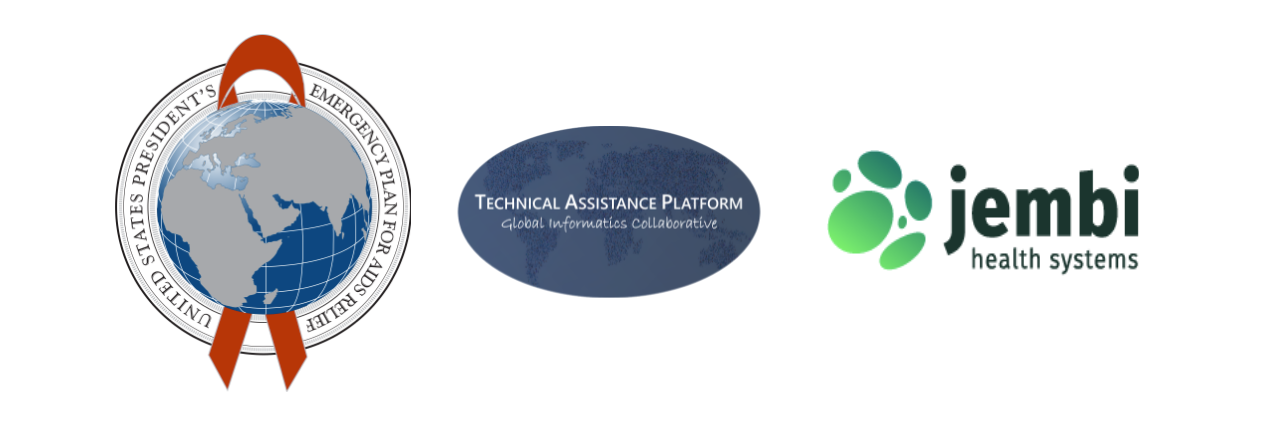

# **<font color="#007f68"> Fastlink_R (Deduplication) Notebook**

In [ ]:
#@title <font color="#18CF68">Installations
!pip install rpy2

In [ ]:
#@title <font color="#18CF68">Imports
import pandas as pd
import logging
from rpy2.robjects import globalenv
from rpy2.robjects.vectors import StrVector
import rpy2.robjects as r_objects
import rpy2.robjects.packages as r_packages
r = r_objects.r

from ipywidgets import Dropdown
from ipywidgets import FloatSlider
from ipywidgets import Text
from ipywidgets import GridBox
from ipywidgets import Checkbox

import matplotlib.pyplot as plt

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)
logging.info('Started')

# Fastlink imports
utils = r_packages.importr('utils')
utils.chooseCRANmirror(ind=1)
pack_names = ('fastLink', 'tictoc', 'strex', 'data.table', 'csv')
names_to_install = [x for x in pack_names if not r_packages.isinstalled(x)]
if len(names_to_install) > 0:
  utils.install_packages(StrVector(names_to_install))
base = r_packages.importr('base')
stats = r_packages.importr('stats')
fastLink = r_packages.importr('fastLink')
strex = r_packages.importr('strex')
data_table = r_packages.importr('data.table')

In [3]:
#@title <font color="#18CF68">Choose local csv file
from google.colab import files
uploaded = files.upload()

Saving data-50-25.csv to data-50-25.csv


In [6]:
#@title <font color="#18CF68">Read data
globalenv['csv'] = r['read.csv']('data-50-25.csv', header=True, stringsAsFactors=False)
col_names_r = r('colnames(csv)')
col_names = list(col_names_r)
r('csv[csv==""] <- NA')
r('dfA <- csv[str_detect(csv$ID, "-aaa-"), ]')
r('dfB <- csv[str_detect(csv$ID, "-bbb-"), ]')
s = r('structure(list(csv = csv, dfA = dfA, dfB = dfB))')
# s = r('csv')
print(col_names)

menu_1 = Dropdown(description="Choose your unique identifier", options=col_names)
display(menu_1)
for i in range(len(col_names)):
  check_b = Checkbox(value=False, description=col_names[i], disabled=False, indent=False)
  display(check_b)
menu_2 = Dropdown(description="Choose your string distance algorithm", options=["Jaro-Winkler", "Levensthein"])
slider_1 = FloatSlider(description="cut.a:", value=0.94, min=0, max=1, step=0.01)
slider_2 = FloatSlider(description="cut.p:", value=0.88, min=0, max=1, step=0.01)
display(menu_2, slider_1, slider_2)

['ID', 'hivCaseReportNumber', 'name', 'fathersName', 'fathersFatherName', 'mothersName', 'mothersFatherName', 'gender', 'dob', 'district', 'town', 'PhoneNumber']


Dropdown(description='Choose your unique identifier', options=('ID', 'hivCaseReportNumber', 'name', 'fathersNa…

Checkbox(value=False, description='ID', indent=False)

Checkbox(value=False, description='hivCaseReportNumber', indent=False)

Checkbox(value=False, description='name', indent=False)

Checkbox(value=False, description='fathersName', indent=False)

Checkbox(value=False, description='fathersFatherName', indent=False)

Checkbox(value=False, description='mothersName', indent=False)

Checkbox(value=False, description='mothersFatherName', indent=False)

Checkbox(value=False, description='gender', indent=False)

Checkbox(value=False, description='dob', indent=False)

Checkbox(value=False, description='district', indent=False)

Checkbox(value=False, description='town', indent=False)

Checkbox(value=False, description='PhoneNumber', indent=False)

Dropdown(description='Choose your string distance algorithm', options=('Jaro-Winkler', 'Levensthein'), value='…

FloatSlider(value=0.94, description='cut.a:', max=1.0, step=0.01)

FloatSlider(value=0.88, description='cut.p:', max=1.0, step=0.01)

In [ ]:
#@title <font color="#18CF68">Run fastlink
key = menu_1.value
string_distance = menu_2.value
if string_distance == "Jaro-Winkler":
  string_distance = "jw"
else:
  string_distance = "lv"
cut_a = slider_1.value
cut_p = slider_2.value

logging.info("FastLink : initialized")

df_a = s
def fl_dedupe(df_a, key, string_distance, cut_a, cut_p):
        get_dedupes = r('''
            my_fl_dedupe <- function(df_a) {{        
                pasteT <- function(x) {{
                    x <- sort(x)
                    x <- paste(x, collapse = ",")
                    x
                }}
                varnames      <- colnames(csv)
                varnames      <- varnames[-which(varnames %in% c('{0}'))]
                fl_out        <- fastLink(dfA = csv, dfB = csv, varnames = varnames,
                                          stringdist.match = varnames, stringdist.method = '{1}', cut.a = {2}, 
                                          cut.p = c(0.80, {3}), dedupe.matches = TRUE, linprog.dedupe = FALSE,
                                          cond.indep = 'TRUE',
                                          n.cores = 8,
                                          verbose = 'TRUE')
                inds_ab <- data.table(cbind(fl_out$matches$inds.a, fl_out$matches$inds.b))
                inds_ab[, `:=`(V3, pasteT(V2)), by = V1]
                inds_ab <- inds_ab[,.(V1, V3)]
                inds_ab <- inds_ab[!duplicated(inds_ab)]
                setnames(inds_ab, 'V3', 'V2')
                inds_ab <- unique(inds_ab[,list(V2)])
                structure(list(fl_out = fl_out, inds_ab = inds_ab))
            }}
            '''.format(key, string_distance, cut_a, cut_p))
        return get_dedupes(df_a)

def analytics(process):
  varnames = tuple(globalenv['{0}'.format(process)].rx2('fl_out').rx2('EM').rx2('varnames'))
  logging.info(('{0}: %s'.format(process), tuple(globalenv['{0}'.format(process)].names)))
  logging.info('fl_out: %s', tuple(globalenv['{0}'.format(process)].rx2('fl_out').names))
  logging.info('fl_out: %s', tuple(globalenv['{0}'.format(process)].rx2('fl_out').rx2('matches').names))
  logging.info('EM: %s', tuple(globalenv['{0}'.format(process)].rx2('fl_out').rx2('EM').names))
  logging.info('patterns.w: %s', tuple(globalenv['{0}'.format(process)].rx2('fl_out').rx2('EM').rx2('patterns.w').names[1]))
  logging.info('varnames: %s', tuple(globalenv['{0}'.format(process)].rx2('fl_out').rx2('EM').rx2('varnames')))
  logging.info('patterns: %s', tuple(globalenv['{0}'.format(process)].rx2('fl_out').rx2('patterns').names))
  logging.info('inds_ab: %s', tuple(globalenv['{0}'.format(process)].rx2('inds_ab').names))
  # The posterior probability of a pair matching.
  logging.info('p.m: %f', r('{0}$fl_out$EM$p.m'.format(process))[0])
  # The posterior probability of a pair not matching.
  logging.info('p.u: %f', r('{0}$fl_out$EM$p.u'.format(process))[0])
  # The posterior of the matching prVobability for a specific matching field.
  logging.info("EM.p.gamma.k.m")
  em_p_gamma_k_m = []
  for i in range(len(r('{0}$fl_out$EM$p.gamma.k.m'.format(process)))):
    placeholder = ['p.gamma.k.m ----- %-20s : %3.10f  %3.10f  %3.10f',
                    varnames[i],
                    r('{0}$fl_out$EM$p.gamma.k.m'.format(process))[i][0],
                    abs(r('{0}$fl_out$EM$p.gamma.k.m'.format(process))[i][1]),
                    r('{0}$fl_out$EM$p.gamma.k.m'.format(process))[i][0] + r('{0}$fl_out$EM$p.gamma.k.m'.format(process))[i][1]]
    em_p_gamma_k_m.append(placeholder)
    logging.info('p.gamma.k.m ----- %-20s : %3.10f  %3.10f  %3.10f',
                  varnames[i],
                  r('{0}$fl_out$EM$p.gamma.k.m'.format(process))[i][0],
                  abs(r('{0}$fl_out$EM$p.gamma.k.m'.format(process))[i][1]),
                  r('{0}$fl_out$EM$p.gamma.k.m'.format(process))[i][0] + r('{0}$fl_out$EM$p.gamma.k.m'.format(process))[i][1])
  # The posterior of the non-matching probability for a specific matching field.
  logging.info("EM.p.gamma.k.u")
  em_p_gamma_k_u = []
  for i in range(len(r('{0}$fl_out$EM$p.gamma.k.u'.format(process)))):
    placeholder = ['p.gamma.k.u ----- %-20s : %3.10f  %3.10f  %3.10f',
                    varnames[i],
                    abs(r('{0}$fl_out$EM$p.gamma.k.u'.format(process))[i][0]),
                    r('{0}$fl_out$EM$p.gamma.k.u'.format(process))[i][1],
                    r('{0}$fl_out$EM$p.gamma.k.u'.format(process))[i][0] + r('{0}$fl_out$EM$p.gamma.k.u'.format(process))[i][1]]
    em_p_gamma_k_u.append(placeholder)
    logging.info('p.gamma.k.u ----- %-20s : %3.10f  %3.10f  %3.10f',
                  varnames[i],
                  abs(r('{0}$fl_out$EM$p.gamma.k.u'.format(process))[i][0]),
                  r('{0}$fl_out$EM$p.gamma.k.u'.format(process))[i][1],
                  r('{0}$fl_out$EM$p.gamma.k.u'.format(process))[i][0] + r('{0}$fl_out$EM$p.gamma.k.u'.format(process))[i][1])
  logging.info('iter.converge: %d', r('{0}$fl_out$EM$iter.converge'.format(process))[0])
  return varnames, em_p_gamma_k_m, em_p_gamma_k_u

globalenv['dedupes'] = fl_dedupe(df_a, key, string_distance, cut_a, cut_p)
log_info = analytics('dedupes')
varnames = log_info[0]
em_p_gamma_k_m = log_info[1]
em_p_gamma_k_u = log_info[2]
v2 = tuple(r('dedupes$inds_ab$V2'))

In [ ]:
#@title <font color="#18CF68">Identify reference records
fields = tuple(col_names)
left = pd.DataFrame(columns=('key',) + fields)
right = pd.DataFrame(columns=('key',) + fields)
k = 0
max_no_dup = 0

for i in range(len(v2)):  # TODO: Add logging info for true and false positives
  dupe_links = tuple(map(int, v2[i].split(',')))
  if len(dupe_links) > max_no_dup:
    max_no_dup = len(dupe_links)
  dup = []
  master = r('csv[{},]'.format(dupe_links[0]))
  for j in range(1, len(dupe_links)):
    count_1 = 0
    for u in range(len(master)):
      if str(master.rx2(u + 1)[0]) == "NA":
        count_1 += 1

    holder = r('csv[{},]'.format(dupe_links[j]))
    count_2 = 0
    for h in range(len(holder)):
      if str(holder.rx2(h + 1)[0]) == "NA":
        count_2 += 1

    if count_1 > count_2:
      right.loc[k] = (i,) + tuple(map(lambda x: str(master.rx2(x)[0]), fields))
      k = k + 1
      master = holder
    else:
      right.loc[k] = (i,) + tuple(map(lambda x: str(holder.rx2(x)[0]), fields))
      k = k + 1
  left.loc[i] = (i,) + tuple(map(lambda x: str(master.rx2(x)[0]), fields))

In [ ]:
#@title <font color="#18CF68">Display results
false_positives = 0
true_positives = 0
false_negatives = 0
true_negatives = 0

col = (('key',) + fields) * max_no_dup
l_and_r = pd.DataFrame(columns=col)
empty_tup = ("",) * len(('key',) + fields)

for i in range(left.shape[0]):
  pop_tup = ()
  pop_tup = tuple(left.values[i])
  count = 0
  for j in range(right.shape[0]):
    if right.values[j][0] == left.values[i][0]:
      pop_tup = pop_tup + tuple(right.values[j])
      count = count + 1
      if left.values[i][1][:12] == right.values[j][1][:12]:
        true_positives = true_positives + 1
      else:
        false_positives = false_positives + 1
  pop_tup = pop_tup + (empty_tup * ((max_no_dup - 1) - count))
  if (max_no_dup - 1) - count == 3:
    for k in range(len(left)):
      neg_count = 0
      if left.values[k][1][:12] == pop_tup[1][:12]:
        neg_count = neg_count + 1
    if neg_count < 2:
      true_negatives = true_negatives + 1
    else:
      false_negatives = false_negatives + 1
  l_and_r.loc[i] = pop_tup
display(l_and_r)


,key,ID,hivCaseReportNumber,name,fathersName,fathersFatherName,mothersName,mothersFatherName,gender,dob,district,town,PhoneNumber,key,ID,hivCaseReportNumber,name,fathersName,fathersFatherName,mothersName,mothersFatherName,gender,dob,district,town,PhoneNumber,key,ID,hivCaseReportNumber,name,fathersName,fathersFatherName,mothersName,mothersFatherName,gender,dob,district,town,PhoneNumber,key,ID,hivCaseReportNumber,name,fathersName,fathersFatherName,mothersName,mothersFatherName,gender,dob,district,town,PhoneNumber
0,0,rec-00000000-aaa-0,vz/6z/GlK/LadDW,Tolosa,Henock,Kebede,Kiros,Ayele,male,20050324,SNNP,Duna,011-655-1890,0,rec-00000000-bbb-0,NA_character_,Tolosta,Henokk,Kebede,Kiros,Ayel,male,20050324,SNNP,Duna,011-655-1890,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,rec-00000001-aaa-0,52/Kj/tkM/2cNVE,Gubena,Genet,Hassen,Seboka,Mohammed,male,20080622,Oromia,Sayo,033-619-0743,1,rec-00000001-bbb-0,52/Kj/tkM/2cNVE,Gubena,Gened,Hasse,Seboka,Mohammed,maoe,20080622,Oromia,Say9,033-619-0743,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,rec-00000002-aaa-0,Vc/UN/BlV/7V8WF,Meles,Habtezgi,Alemseged,Wakene,Woldetsaoik,male,19940610,Afar,Telalek,091-720-1380,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,rec-00000003-aaa-0,W5/NT/vrS/Qd3cJ,Desta,Bayitu,Alemneh,Aemero,Abdurehman,male,19940228,Somali,Babile,022-599-9955,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,rec-00000004-aaa-0,i3/Hf/qq3/tRT6K,Marta,Busha,Araya,Yosef,Hasen,female,20110810,Oromia,Sebeta town,011-651-1671,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,5,rec-00000005-aaa-0,jP/vo/pq8/EkSUX,Zerihun,Tenaw,Kebede,Utalo,Kibrom,male,20000121,Amhara,East Belesa,022-310-0181,5,rec-00000005-bbb-0,jP/vo/pq8/EkSUX,NA_character_,Tenaw,Kebede,Utalo,Kiprom,male,NA_character_,Amhara,East Belesa,022-310-p181,,,,,,,,,,,,,,,,,,,,,,,,,,
6,6,rec-00000006-aaa-0,Xa/SH/N3J/ejUqF,Wolde,Tesfaye,Gebretsadik,Yonas,Bogale,male,20010501,SNNP,Basketo SP Woreda,011-655-6608,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,7,rec-00000007-aaa-0,a7/qH/dFi/HDQbZ,Ebrahim,Mohammed,Tedila,Mekonnen,Molalegn,male,20060830,Oromia,Becho (SW Shewa),047-381-4848,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,8,rec-00000008-aaa-0,ks/pP/5TZ/2kOde,Mulie,Alemneh,Menilik,Mekonnen,Tegegn,male,20040110,Oromia,Kuyu,091-837-8346,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,9,rec-00000009-aaa-0,iR/Nu/GZK/YqeU8,Sara,Kebede,Getaneh,Alemayehu,Gebrekiros,female,19971001,Sidama,Hawasa town,011-112-6142,9,rec-00000009-bbb-0,iR/Nu/GZK/YqeU8,Sara,Kebede,Getaneh,Alemayeu,Gebrekiros,NA_character_,19971001,Sidana,Hawasa t0wn,011-112-6142,9,rec-00000009-bbb-1,iR/Nu/GZK/YqeU8,Sara,Kebete,Getaneh,Alemayeu,Geprekiros,NA_character_,19971001,Sidama,Hawasa town,011-112-6142,,,,,,,,,,,,,


Text(0.5, 1.0, 'Pie charts showing Recall, Precision and F_score')

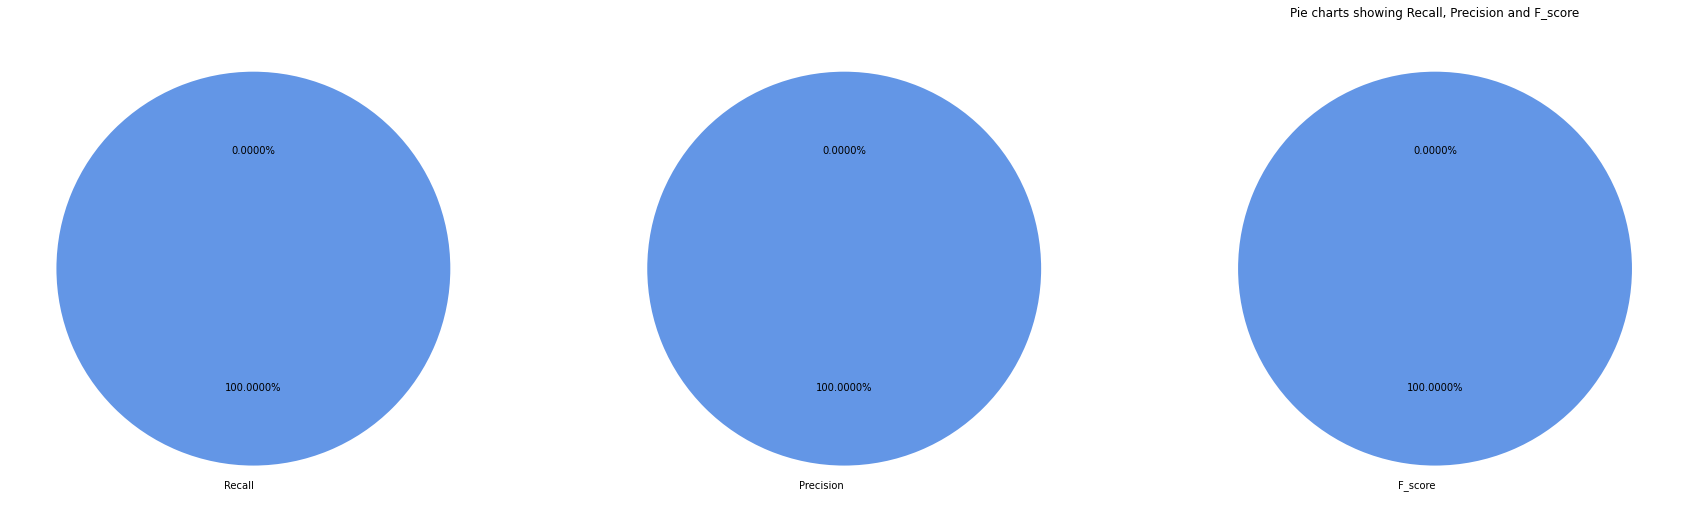

In [ ]:
#@title <font color="#18CF68">Recall, precisions and F_score results

recall = true_positives/(true_positives + false_negatives)
recall_labels = ["Recall", " "]
recall_sections = [recall, 1 - recall]

precision = true_positives/(true_positives + false_positives)
prec_labels = ["Precision", " "]
prec_sections = [precision, 1 - precision]

f_score = 2 * ((precision * recall)/(precision + recall))
f_labels = ["F_score", " "]
f_sections = [f_score, 1 - f_score]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
colors = ["#6396e6", "#de73e6"]

axes[0].pie(recall_sections, 
        labels=recall_labels, 
        colors=colors, 
        startangle=90,
        autopct='%1.4f%%')
axes[1].pie(prec_sections, 
        labels=prec_labels, 
        colors=colors,
        startangle=90, 
        autopct='%1.4f%%')
axes[2].pie(f_sections, 
        labels=f_labels, 
        colors=colors, 
        startangle=90, 
        autopct='%1.4f%%')

plt.title("Pie charts showing Recall, Precision and F_score")

# print(recall)
# print(precision)
# print(f_score)

In [ ]:
#@title <font color="#18CF68">Display Fellegi/Sunter weights
for m in range(2):
  if m == 0:
    weight = em_p_gamma_k_m
    w_label = Text(value="Matches", disabled=True)
  else:
    weight = em_p_gamma_k_u
    w_label = Text(value="Unmatches", disabled=True)
  
  w_min = weight[0][2]
  for i in range(1, len(weight)):
    if weight[i][2] < w_min:
      w_min = weight[i][2]

  w_max = weight[0][2]
  for i in range(1, len(weight)):
    if weight[i][2] > w_max:
      w_max = weight[i][2]


for m in range(2):
  if m == 0:
    weight = em_p_gamma_k_m
    w_label = Text(value="Matches", disabled=True)
  else:
    weight = em_p_gamma_k_u
    w_label = Text(value="Unmatches", disabled=True)
  
  # w_min = weight[0][2]
  # for i in range(1, len(weight)):
  #   if weight[i][2] < w_min:
  #     w_min = weight[i][2]

  # w_max = weight[0][2]
  # for i in range(1, len(weight)):
  #   if weight[i][2] > w_max:
  #     w_max = weight[i][2]

  display(w_label)
  for j in range(len(weight)):
    w_slider = FloatSlider(value=weight[j][3], min=w_min, max=w_max, description=weight[j][1], disabled=True)
    display(w_slider)

Text(value='Matches', disabled=True)

FloatSlider(value=0.983193275846171, description='hivCaseReportNumber', disabled=True, max=1.0, min=0.56223506…

FloatSlider(value=0.8055555524022968, description='name', disabled=True, max=1.0, min=0.5622350673442015)

FloatSlider(value=0.8503401272793008, description='fathersName', disabled=True, max=1.0, min=0.562235067344201…

FloatSlider(value=0.9285714252944833, description='fathersFatherName', disabled=True, max=1.0, min=0.562235067…

FloatSlider(value=0.9428571328398372, description='mothersName', disabled=True, max=1.0, min=0.562235067344201…

FloatSlider(value=0.9583333237214797, description='mothersFatherName', disabled=True, max=1.0, min=0.562235067…

FloatSlider(value=0.7841726629420092, description='gender', disabled=True, max=1.0, min=0.5622350673442015)

FloatSlider(value=0.9305555519491374, description='dob', disabled=True, max=1.0, min=0.5622350673442015)

FloatSlider(value=0.8999999941359126, description='district', disabled=True, max=1.0, min=0.5622350673442015)

FloatSlider(value=0.9562043709650937, description='town', disabled=True, max=1.0, min=0.5622350673442015)

FloatSlider(value=0.9854014524003256, description='PhoneNumber', disabled=True, max=1.0, min=0.562235067344201…

Text(value='Unmatches', disabled=True)

FloatSlider(value=0.5622350673442015, description='hivCaseReportNumber', disabled=True, max=1.0, min=0.5622350…

FloatSlider(value=0.5622350673442015, description='name', disabled=True, max=1.0, min=0.5622350673442015)

FloatSlider(value=0.5622350673442015, description='fathersName', disabled=True, max=1.0, min=0.562235067344201…

FloatSlider(value=0.5622350673442015, description='fathersFatherName', disabled=True, max=1.0, min=0.562235067…

FloatSlider(value=0.5622350673442015, description='mothersName', disabled=True, max=1.0, min=0.562235067344201…

FloatSlider(value=0.5622350673442015, description='mothersFatherName', disabled=True, max=1.0, min=0.562235067…

FloatSlider(value=0.5622350673442015, description='gender', disabled=True, max=1.0, min=0.5622350673442015)

FloatSlider(value=0.5622350673442015, description='dob', disabled=True, max=1.0, min=0.5622350673442015)

FloatSlider(value=0.5622350673442015, description='district', disabled=True, max=1.0, min=0.5622350673442015)

FloatSlider(value=0.5622350673442015, description='town', disabled=True, max=1.0, min=0.5622350673442015)

FloatSlider(value=0.5622350673442015, description='PhoneNumber', disabled=True, max=1.0, min=0.562235067344201…